### Situation

Have you ever hopped on a scooter and realized the battery is dead? 😣 What an upsetting experience! 

In order to prevent that horrible user experience from happening, the data science team is focusing its efforts on coming up with the best scooter charging strategy. 

You can find a data set below with scooters’ current geolocation and power level. Power level ranges from 0 - 5 (0 as completely out of battery, 5 as fully charged). It takes 5 hours to charge a scooter’s power from 0 to 5. TechPointX talent team also has a mega charging bus that drives around to pick up scooters and charge them inside. Unfortunately, the bus can only park and start at location 20.19 (xcoordinate), 20.19 (ycoordinate) and only travel 50 miles per hour. 

### Your Task

Review the data set, and draw any conclusions you can find from the data set. Try to identify the most popular scooter location, demonstrate your findings using data visualization tools, calculate operation time cost (Operation Time Cost: How long it takes to fully charge all the scooters), and come up with the most efficient scooter charging strategy.

### Approach

The approach is simple. 
1) If maximum people are to pick up the scooters, we need to make all the scooters functional. People are more likely to pick up the scooters with power level 3 and beyond.
2) Bring all the vehicles to that level first.
3) Then cover all the vehicles with power levels 3 and 4. This way we cover all the vehicles and cater to more poeple

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [67]:
#Read the data
data = pd.read_csv("2019-XTern- Work Sample Assessment Data Science-DS.csv")
print(data.head())
print(data.shape)

   scooter_id  xcoordinate  ycoordinate  power_level
0           0     0.906835     0.776484            0
1           1     0.928587     0.804964            2
2           2     0.904091     0.784043            1
3           3     0.906752     0.804461            0
4           4     0.900641     0.781683            4
(25668, 4)


### Initial Intuition:

We will divide the task in 2 problems:
#### 1) Find the most popular location
#### 2) Find the optimum amount of time needed to fully charge the scooters

### Assumptions
1) 12 units on the axes is equal to 1 mile. 
2) The bus stops at the center of the cluster and the person picks up the scooter. It then charges the scooter and keeps it back. The time required in doing these tasks is ignored.
 



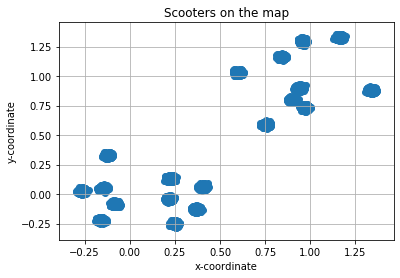

In [68]:
plt.title("Scooters on the map")
plt.scatter(data["xcoordinate"],data["ycoordinate"])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.grid()


## Algorithm and its specifications

If we look at the data, we can see that there are 6 clusters that can be formed easily. Thus, we use the K-means clustering here. But, we need to check if 6 is the optimal number of clusters or not. To do that, we will use the elbow method to deduce the correctness of our clustering.


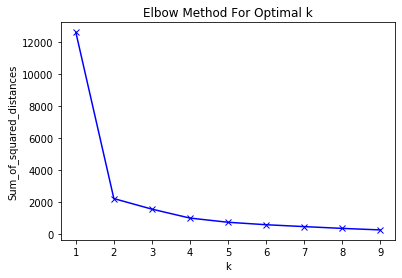

In [69]:
from sklearn.cluster import KMeans
K = range(1,10)
Sum_of_squared_distances = []
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data.iloc[:,1:3])
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In the above plot, we can see that after 6 basically the plot becomes smooth, thus we take 6 clusters.

# Division of the Area
Now that we are sure about 6 clusters to be formed, we can go ahead and perform k-means clustering to visualize what the clusters look like.

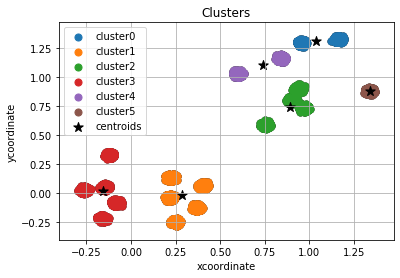

In [70]:

from sklearn.datasets import make_blobs
data.head()
# k-means clustering
k = 6

#k-means clustering 
kmeans = KMeans(n_clusters=k, random_state=0).fit(data.iloc[:,1:3])
plt.scatter(
    data.iloc[:, 1:2], data.iloc[:, 2:3],
    c='black',
    edgecolor='black', s=50
)
# predict the clusters for each scooter
y_km = kmeans.fit_predict(data.iloc[:,1:3])
assign_clust_column = pd.DataFrame(data=y_km, columns=["clust_col"])
# append that column in the original data set
dat = pd.concat([data,assign_clust_column],axis=1)
clusters = []
max_scooters = 0
cluster_id = 0
scooter_total = []
cluster_labels = []
# plot the clusters and maintain them in one place
for i in range(len(np.unique(y_km))):
    clusters.append(dat.loc[dat['clust_col'] == i])
    scooter_total.append(dat.loc[dat['clust_col'] == i].shape[0])
    if dat.loc[dat['clust_col'] == i].shape[0] > max_scooters :
        max_scooters = dat.loc[dat['clust_col'] == i].shape[0]
        cluster_id = i
    plt.scatter(
       clusters[i][["xcoordinate"]], clusters[i][["ycoordinate"]],
       s=50,
       marker='o', 
       label='cluster'+ str(i)
        )
    cluster_labels.append('cluster'+ str(i))

plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=100, marker='*',
    c='black', 
    label='centroids'
)
plt.title("Clusters")
plt.legend(scatterpoints=1)
plt.xlabel("xcoordinate")
plt.ylabel("ycoordinate")
plt.grid()
plt.show()


# 1) Most Popular location 

There are several ways to identify this.
##### a) Maximum number of scooters in an area
        This indicates that since the maximum number of scooters are found in a particular location, that location must be
        the most popular one. 
##### b) Ratio of the discharged to the total number of scooters.
        This indicates that the scooters are more likely to be used by people in a certain area.
We will analyse which technique can be used for our data set as below.



## a) Maximum number of scooters in a area
Here we plot the number of scooters in each cluster.


Text(0.5, 1.0, 'Scooter Density')

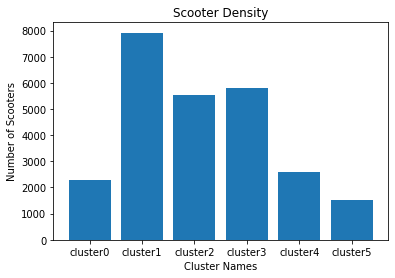

In [71]:
# plot a bar grpah indicating the total scooters in an area.
plt.bar(cluster_labels,scooter_total)
plt.xlabel("Cluster Names")
plt.ylabel("Number of Scooters")
plt.title("Scooter Density")



From the above plot it is quite clear that cluster number 1 has the maximum number of scooters. Thus, according to our assumption that the reason there are many scooters in the area that is covered by cluster 1 is because it being the most popular area.
\
To confirm this we need to check the other possibility


### Assumptions :
1) According to the popular belief, generally supply is done to the areas where there is a huge demand. Thus we decide the popular location on the number of vehicles

## b) Ratio of the discharged to the total number of scooters.
For this we need to calculate some values:
\
1) Total time needed to charge all the scooters
\
2) Which vehicles to charge?
    Strategies to select the vehicles to charge.

In [72]:
total_time_needed_to_charge = (5 - data[["power_level"]]).sum()
print("total time needed to charge all the uncharged scooters",total_time_needed_to_charge)


total time needed to charge all the uncharged scooters power_level    64271
dtype: int64


#### 1) Total time needed to charge all the scooters
So, if we decide to charge all the vehicles, and if the capacity of the bus is to charge 1500 vehicles at a time. Then we would need about 64271/1500 = 42 hours.
But here arises the question. 

##### Do we really need to charge all the vehicles. Can't we prioritize which vehicles to charge and which should not be charged. This way we will reach maximum clusters and cater to maximum number of people
And once, we have charged the most important scooters, we have basically made all the scooters functional. Since, a scooter with a power level of 0 will be never picked up . 
Thus, we will pick up all the scooters but on the basis of some priority.

#### 2) Which vehicles to charge?

We can decide that on the basis of the power levels.
Let's frist plot that and get a glimpse of how that data looks


# Plotting on the basis of the power levels


Text(0, 0.5, 'count')

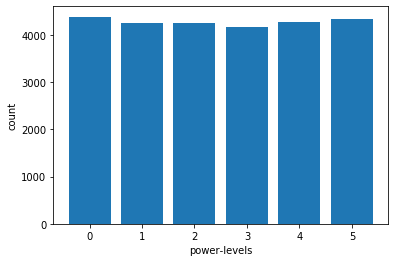

In [73]:
unique,count = np.unique(data[["power_level"]], return_counts=True)
plt.bar(unique,count)
plt.xlabel("power-levels")
plt.ylabel("count")

The above plots indicates that the number of scooters in each power level is almost same for all the power levels. Therefore, in order to target more customers, we will come up with the following strategy.

### Assumptions:
\
1) People sleep at night and very few people use scooters at night. Thus the scooters are used in the 12 hours of the day leaving the night time.
\
2) Prioritization: Here, we realize that we do not need to charge all the scooters while going from one cluster to the another on the basis of the following calculations.
\
The average time taken by a cycle to get discharged is considerably higher than the time it takes for it to charge. Suppose, if we assume that the charge in a fully charged motor cycle lasts for 15 hours. 
\
Then, the time taken by a scooter on power level 4 will be 12 hours. Again, assuming that a scooter is generally used for short distances, this time is more than sufficient to last for a day.
\
Next if we say that the scooter is on power level 3. Then, it will last for 9 hours.This, according to me is still a good enough time for the scooter to be in a useful condition for one day. 

Thus, we need to charge only those scooters that have the power levels within 0-2 while going from one cluster to another in the first round. 
We can then completely charge the rest with power levels 3,4,5. 


# Prioritizing which scooters to charge on the basis of the their power levels

For each cluster, we will see how is the distribution of the data w.r.t. the pwer level 0-2 is

In [74]:
#total number of scooters with power levels 0 ,1 and 2
scooters_targeted = data.loc[data['power_level'].isin([0,1,2])]

print("number of scooters to be charged",scooters_targeted.shape[0])


number of scooters to be charged 12881


This we know that we need to charge 12881 scooters in total in all the clusters. Now we will prioritize which ones to charge first. For that we will see in each cluster, which is the most popular one.
Let us visualize this data.

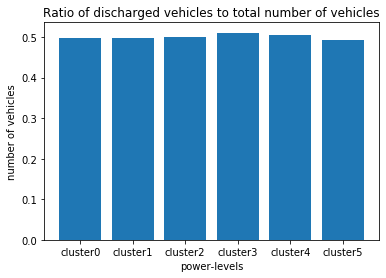

In [75]:
cluster_dict = {}

length_clusters = []
#sort the locations on the basis of the location with the most number of scooters
for i in range(len(clusters)):
    cluster_dict["cluster"+str(i)] = clusters[i]
cluster_name = []
count_ratio = []
for i in cluster_dict:
    curr_cluster = cluster_dict.get(i)
    vehicles_to_be_charged = curr_cluster.loc[curr_cluster['power_level'].isin([0,1,2])]
    unique_val,count_tot = np.unique(vehicles_to_be_charged[["power_level"]], return_counts=True)
    cluster_name.append(i)
    count_ratio.append(sum(count_tot)/curr_cluster.shape[0])
plt.bar(cluster_name, count_ratio)
plt.xlabel("power-levels")
plt.ylabel("number of vehicles")
plt.title("Ratio of discharged vehicles to total number of vehicles")
plt.show()

#visualizing for each cluster



Here we see that, the ratio for each place is almost the same. Thus, this indicates that almost 50% scooters in each cluster are used for any region. 
This does not give us an intuition on the popularity. So we will go with the other option of the total number of scooters in an area.
This is based on the assumption that, people are equally likely to ride the scooters in an area so we will target the cluster that has the maximum number of scooters first.
Also, if we sort the clusters on the basis of total number of scooters in an area, we see that the we can take ride the bus in that order in less distance.


#####  According to the data above, we can see that, we cannot choose the most popular location on the basis of the ratio of the discharges to the total number of vehicles, since it is almost similar for each cluster. Thus We choose the first strategy and decide the most popular location the basis of maximum data

## Ordering the clusters on the basis of the priority in which they should be charged

In [76]:
order = sorted(cluster_dict, key=lambda k: cluster_dict[k].shape[0], reverse=True) 
print(order)


['cluster1', 'cluster3', 'cluster2', 'cluster4', 'cluster0', 'cluster5']


That is, according to our ordered list of clusters we will traverse from cluster 1, cluster 3, cluster2, cluster4, cluster0, cluster5.

# 2) Time taken to charge the scooters
Now that we have narrowed the data to the point where we have decided that we will only charge the scooters in power levels 0,1,2 in the first iteration We have to charge 12881 vehicles while going from parking to each cluster. On the way back we will again visit all the clusters and charge the remaining vehicles with power levels 3,4,5.
We will see in that how many hours will be needed in total to do that.




In [77]:
total_time_for_targeted_scooters = (5 - scooters_targeted[["power_level"]]).sum()
print(total_time_for_targeted_scooters)

power_level    51667
dtype: int64


Now the total time needed will reduce to 51,667 hours. Now we need to first target the clusters on the basis of order in which they were targetted.
For that first we will see how does the bus travel in what time. We have been given that the bus travels at a speed of 50miles/hour
So the distance from the parking of the bus to the center of the first cluster  is found out by the Euclidean distance. after that we will travel to the center of the other clusters. 
Thus, this total distance will always remain the same. we will calculate that first.


In [78]:
print(order)
parking_coordinates = [20.19,20.19]
euclidean_dist = 0
kmeans.cluster_centers_
for i in order:
    index = int(i[-1])
    co_ordinates = kmeans.cluster_centers_[index]
    if(index == 1):
        euclidean_dist += np.sqrt(pow((co_ordinates[0]-parking_coordinates[0]),2)+ pow((co_ordinates[1]-parking_coordinates[1]),2))
        previous_coordinates = [co_ordinates[0],co_ordinates[1]]
    else:
        euclidean_dist += np.sqrt(pow((previous_coordinates[0]-co_ordinates[1]),2)+ pow((previous_coordinates[1]-co_ordinates[1]),2))
        previous_coordinates = [co_ordinates[0],co_ordinates[1]]

print(euclidean_dist)


['cluster1', 'cluster3', 'cluster2', 'cluster4', 'cluster0', 'cluster5']
31.288965231099077


The euclidean distance to reach all the center of the centroids is 31.288 units. since 12 units is equal to 1 mile.
we have to travel approximately 2.6 miles while going.
Likewise for coming back after charging all the scooters with priority 0,1,2 we will trace the same path back and cover all the scooters with a power level of 3,4,5. 
The distance will approximately be similar to the distance taken to cover the clusters once.
Thus, here we simple double the distance.


In [79]:
total_dist = euclidean_dist * 2
print("the total distance coverd", total_dist)


the total distance coverd 62.577930462198154


So the total distance needed to come back is approximately 62/12 = 5.1 miles

The bus travles at a speed of 50 miles/hour
The time needed to go and come back is given below


In [80]:
total_time_in_travelling = 5.1/50
print(str(total_time_in_travelling)+" hours")

0.102 hours


Now we need to find the time taken to charge the sccoters in each cluster considering we are only going to charge the scooters with 
#### power levels 0,1,2
We assume that the bus can charge 1500 scooters in one batch. Thus the average time taken to charge all the scooters is given below
And since we have assumed that it will take a long time to get discharged, we will charge the scooters completely, so that they can be resued easily without having to charge again for a long time.




In [81]:
tot_hours = 0
hours = 0
for i in cluster_dict:
    curr_cluster = cluster_dict.get(i)
    vehicles_to_be_charged = curr_cluster.loc[curr_cluster['power_level'].isin([0,1,2])]
    data1 = vehicles_to_be_charged.copy()
        
    data1["charge_time"] = 5 - data1["power_level"]
    hours += data1["charge_time"].sum()
print("The total time required to charge the scooters completely is ",hours/1500, "hours")

The total time required to charge the scooters completely is  34.44466666666667 hours


Now we need to find the time taken to charge the sccoters in each cluster considering we are only going to charge the scooters with

#### power levels 3,4,5
We assume that the bus can charge 1500 scooters in one batch. Thus the average time taken to charge all the scooters is given below And since we have assumed that it will take a long time to get discharged, we will charge the scooters completely, so that they can be resued easily without having to charge again for a long time.

In [82]:
tot_hours = 0
hours = 0
for i in cluster_dict:
    curr_cluster = cluster_dict.get(i)
    vehicles_to_be_charged = curr_cluster.loc[curr_cluster['power_level'].isin([3,4])]
    data1 = vehicles_to_be_charged.copy()
        
    data1["charge_time"] = 5 - data1["power_level"]
    hours += data1["charge_time"].sum()
print("The total time required to charge the scooters completely is ",hours/1500, "hours")

The total time required to charge the scooters completely is  8.402666666666667 hours


The total number of hours needed to completely charge all the vehicles is 34+8 = 42 hours
The total time needed to travel + charge the vehicles = 42 + 0.102 = 43 hours
Here, we assume that, the bus does not come back until it covers all the vehicles at least once. 


# Conclusion:

Here we see that to charge all the scooters, we need to prioritize using two basic assumtions. 
1) People are most likely to pick up a scooters if it is charged above 2 levels.So make the scooter functional.
2) The discharge time of scooter is very high compared to the charging time. Thus, a fully charged vehicle can be used for a long time

Using this the time needed is 43 hours.

    